## Product Review Analysis

### Overview

Customer product reviews play key role in online retail platforms such as amazon. The product reviews are not only useful for customers but also for amazon. This project aims to analyze product review data to come up with useful insights. Though product review doesn't look like a social network data, this project demonstrate how a network could be constructed from customer reviews linking reviewers and products. Once the network is constructed then network analysis techniques could be used to derive useful information. This project also does text analysis of the review comments to see keywords associated with ratings.

### Objective

The high level objectives of this project are 
1. Construct a bipartite network from Product review data 
2. Use unsupervised learning algorithm (hierarchal clustering) cluster customers and products
2. Process product review comment text and build a model to predict the rating and analyze keywords associated with ratings



In [1]:
#Load all Required Pacakges
import networkx as nx
import networkx.algorithms.bipartite as bi
import matplotlib
import numpy as np
import pandas as pd
#Libaray to handle distance
import scipy.spatial.distance as ssd
#to read gzip file
import gzip
import nltk as nltk
#Regular expression for text processing
import re
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn import svm
import scipy.cluster.hierarchy as hicl 
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (14,10)

### Data
For this project amazon product review data to be used. The data is available on below website
http://jmcauley.ucsd.edu/data/amazon/. The data contains more than 10,000 user reviews of 900 amazon products.  

In [2]:
#Review file
review_file = gzip.open("DATA/reviews.json.gz", 'r') 
reviews = []
#Read review as list of dictionary
for f in review_file:
    reviews.append(eval(f))
print "Number of reviews:",len(reviews)
#Preview data
reviews[0:2]


Number of reviews: 10261


[{'asin': '1384719342',
  'helpful': [0, 0],
  'overall': 5.0,
  'reviewText': "Not much to write about here, but it does exactly what it's supposed to. filters out the pop sounds. now my recordings are much more crisp. it is one of the lowest prices pop filters on amazon so might as well buy it, they honestly work the same despite their pricing,",
  'reviewTime': '02 28, 2014',
  'reviewerID': 'A2IBPI20UZIR0U',
  'reviewerName': 'cassandra tu "Yeah, well, that\'s just like, u...',
  'summary': 'good',
  'unixReviewTime': 1393545600},
 {'asin': '1384719342',
  'helpful': [13, 14],
  'overall': 5.0,
  'reviewText': "The product does exactly as it should and is quite affordable.I did not realized it was double screened until it arrived, so it was even better than I had expected.As an added bonus, one of the screens carries a small hint of the smell of an old grape candy I used to buy, so for reminiscent's sake, I cannot stop putting the pop filter next to my nose and smelling it after re

### Parsing Data
The data is provided in json format. The data contains reviewer id, product Id, Reviewer name, review text and overall rating. The data is read into python as list of dictionary. Then a panda dataframe is created from the list of dictionary in order to extract required information.  

In [3]:
#Create dataframe from list of dictionary 
reviews_df=pd.DataFrame.from_dict(reviews)
reviews_df[0:5]

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,1384719342,"[0, 0]",5.0,"Not much to write about here, but it does exac...","02 28, 2014",A2IBPI20UZIR0U,"cassandra tu ""Yeah, well, that's just like, u...",good,1393545600
1,1384719342,"[13, 14]",5.0,The product does exactly as it should and is q...,"03 16, 2013",A14VAT5EAX3D9S,Jake,Jake,1363392000
2,1384719342,"[1, 1]",5.0,The primary job of this device is to block the...,"08 28, 2013",A195EZSQDW3E21,"Rick Bennette ""Rick Bennette""",It Does The Job Well,1377648000
3,1384719342,"[0, 0]",5.0,Nice windscreen protects my MXL mic and preven...,"02 14, 2014",A2C00NNG1ZQQG2,"RustyBill ""Sunday Rocker""",GOOD WINDSCREEN FOR THE MONEY,1392336000
4,1384719342,"[0, 0]",5.0,This pop filter is great. It looks and perform...,"02 21, 2014",A94QU4C90B1AX,SEAN MASLANKA,No more pops when I record my vocals.,1392940800


### Approach

The high-level approach for analytics is as follows

- Parse the data and obtain product review and attributes
- Scan the product review attributes and build a two-node network consisting of users and product
- Use bipartite projections to get relationship between reviewers and products
- Using network clustering technique to obtain a cluster of products and users
- Extract product review comment, normalize text and build text corpus
- Use bag of words technique and classification model to predict rating


The list of products are obtained by extracting the product Id (asin) and removing duplicates. This data file does not contain product names. Similarly the list of reviewers are obtained by extracting and de-duplicating reviewerID.

In [4]:
products=reviews_df["asin"].drop_duplicates()
print "Number of Products",len(products)
print products[0:5]

Number of Products 900
0     1384719342
5     B00004Y2UT
11    B00005ML71
16    B000068NSX
23    B000068NTU
Name: asin, dtype: object


In [5]:
reviewers=reviews_df[["reviewerID","reviewerName"]].drop_duplicates(subset="reviewerID")
print "Number of Reviewers",len(reviewers)
print reviewers[0:5]

Number of Reviewers 1429
       reviewerID                                      reviewerName
0  A2IBPI20UZIR0U  cassandra tu "Yeah, well, that's just like, u...
1  A14VAT5EAX3D9S                                              Jake
2  A195EZSQDW3E21                     Rick Bennette "Rick Bennette"
3  A2C00NNG1ZQQG2                         RustyBill "Sunday Rocker"
4   A94QU4C90B1AX                                     SEAN MASLANKA


#### Bipartite Graph

A two node (bipartite) graph is created using the list of products and reviewers with products as one type of node and reviewers as another type of node.

In [6]:
review_graph=nx.Graph()
review_nodes=[(r,{"name":n}) for r,n in zip(reviewers['reviewerID'],reviewers["reviewerName"])]
review_graph.add_nodes_from(review_nodes,bipartite=0)
review_graph.nodes(data=True)[0:5]

[('A34G1GTMQGEDUN',
  {'bipartite': 0, 'name': 'Johanna Livingstone "Honest Reviewer"'}),
 ('A8OBY4EP2OCDZ', {'bipartite': 0, 'name': 'Brendon'}),
 ('AQOQUWM58SGFR', {'bipartite': 0, 'name': 'rmblack'}),
 ('A1OZ7F08MNF320', {'bipartite': 0, 'name': 'Salik ali "Honest Reviewer"'}),
 ('A2CIR2MO07ZIY3', {'bipartite': 0, 'name': 'M. Wilhelm'})]

In [7]:
#Add product nodes
product_nodes=[(p,{"name":i}) for i,p in enumerate(products)]
review_graph.add_nodes_from(product_nodes,bipartite=1)
review_graph.nodes(data=True)[1429:1433]

[('B0002CZUUG', {'bipartite': 1, 'name': 31}),
 ('B0002E1NNC', {'bipartite': 1, 'name': 99}),
 ('B004Z8VQ2O', {'bipartite': 1, 'name': 764}),
 ('AB7WPLA1CN5I1', {'bipartite': 0, 'name': 'Mark'})]

The edge of the graph represents a review. So, the review data is parsed to come up with list of edges which are then added to the graph. 

In [8]:
#Edge List
edges=[(r,p) for r,p in zip(reviews_df["reviewerID"],reviews_df["asin"])]
review_graph.add_edges_from(edges)

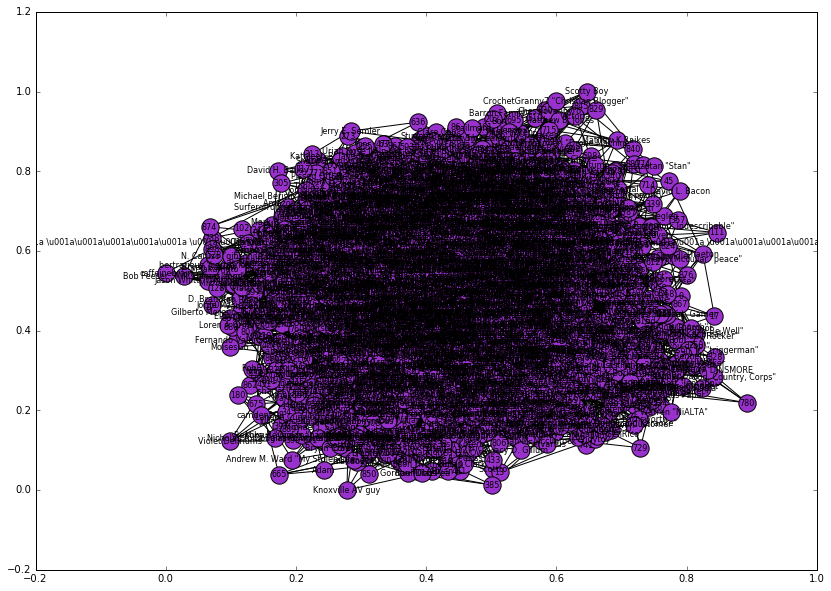

In [9]:
nx.draw_networkx(review_graph,labels=nx.get_node_attributes(review_graph,"name"),
                 font_size=8,node_color='darkorchid')

#### Explore the graph

In [10]:
reviewer_nodes=[n for n,a in review_nodes]
degrees = nx.degree(review_graph,reviewer_nodes)
max_degree=max(degrees,key=degrees.get)
print "Max number of degree(reviews): ",degrees[max_degree]
print "Reviewer with max degree: ", review_graph.node[max_degree]["name"]
min_degree=min(degrees,key=degrees.get)
print "Min degree  of reveiewer ",degrees[min_degree]
print "Reviewer with min degree ",review_graph.node[min_degree]["name"]

Max number of degree(reviews):  42
Reviewer with max degree:  StormJH1
Min degree  of reveiewer  5
Reviewer with min degree  Johanna Livingstone "Honest Reviewer"


In [11]:
degrees = nx.degree(review_graph,products)
max_degree=max(degrees,key=degrees.get)
print "Max number of degree(reviews) of product: ",degrees[max_degree]
print "Product with max degree: ", max_degree
min_degree=min(degrees,key=degrees.get)
print "Min degree of product ",degrees[min_degree]
print "Product with min degree ",min_degree

Max number of degree(reviews) of product:  163
Product with max degree:  B003VWJ2K8
Min degree of product  5
Product with min degree  B0002E3MRW


#### Reviewer Network
The relationship between the reviewers  based on the shared products could be arrived by weighted projection of the review graph by reviewers.

In [12]:
reviewer_network=bi.weighted_projected_graph(review_graph,reviewer_nodes)

In [13]:
degrees = nx.degree(reviewer_network)
max_degree=max(degrees,key=degrees.get)
print "Max number of degree(shared reviews): ",degrees[max_degree]
print "Reviewer with max degree(shared reviews): ", reviewer_network.node[max_degree]["name"]
min_degree=min(degrees,key=degrees.get)
print "Min degree  of reviewer ",degrees[min_degree]
print "Reviewer with min degree ",reviewer_network.node[min_degree]["name"]

Max number of degree(shared reviews):  727
Reviewer with max degree(shared reviews):  David W "Dave"
Min degree  of reviewer  19
Reviewer with min degree  camden108


The edge weight of the network represents the number of shared products. We could view two reviewers close to each other if they have many shared product reviews. So, the distance between two reviewers are calculated as 1/(number of shared products)

In [14]:
edges = reviewer_network.edges()
for s,t in edges:
    reviewer_network[s][t]['distance']=1.0/reviewer_network[s][t]['weight']
reviewer_network[min_degree]

{'A1C0O09LOLVI39': {'distance': 0.3333333333333333, 'weight': 3},
 'A1FCX548TD6DLP': {'distance': 1.0, 'weight': 1},
 'A1OGTL9EBDTK3N': {'distance': 1.0, 'weight': 1},
 'A1RPTVW5VEOSI': {'distance': 1.0, 'weight': 1},
 'A1T9A8YD2FU9UF': {'distance': 1.0, 'weight': 1},
 'A1UMN04FQ6H32D': {'distance': 1.0, 'weight': 1},
 'A2BB6IKKR4G40J': {'distance': 1.0, 'weight': 1},
 'A2F42NSN3HKRCU': {'distance': 0.3333333333333333, 'weight': 3},
 'A2W8OGJDV7TCMT': {'distance': 1.0, 'weight': 1},
 'A32BCTL0HLOXRV': {'distance': 1.0, 'weight': 1},
 'A37AQI4AU3JWSR': {'distance': 0.5, 'weight': 2},
 'A3CUYX2VXZM9KO': {'distance': 0.5, 'weight': 2},
 'A3FA334BIFOMRD': {'distance': 1.0, 'weight': 1},
 'A3KZ3Y88P6CAMA': {'distance': 1.0, 'weight': 1},
 'A3NHUK1ISMZCFZ': {'distance': 1.0, 'weight': 1},
 'A3SMT15X2QVUR8': {'distance': 0.5, 'weight': 2},
 'A5I7XOLQRH9YE': {'distance': 0.5, 'weight': 2},
 'AFS3FQR5JSDVJ': {'distance': 0.3333333333333333, 'weight': 3},
 'AJCHGS1GND4OA': {'distance': 0.3333333

Using networkx shortest_path function the shortest distance between each reviewers are calculated. 

In [15]:
paths=nx.shortest_path(reviewer_network,weight="distance")
paths['A1C0O09LOLVI39']['A1OZ7F08MNF320']

['A1C0O09LOLVI39', 'AJCHGS1GND4OA', 'A1Q94IXHEGQDV7', 'A1OZ7F08MNF320']

A distance matrix is constructed from the shortest path obtained in order to perform clustering. 

In [16]:
distance_dict=nx.all_pairs_dijkstra_path_length(reviewer_network,weight="distance")
dist_df=pd.DataFrame.from_dict(distance_dict)
reviewers_id=list(dist_df.columns.values)
dist_mat=dist_df.as_matrix()
dist_mat.shape

(1429, 1429)

The scikit package require condensed distance vector for horizantal clustering. So a condensed distance vector is created from the full distance matrix.

In [17]:
condensed_dist=ssd.squareform(X=dist_mat,force='tovector',checks=False)

### Clustering
scikit packages horizontal clustering package is used to come up with cluster of reviewers. For clustering the average graph distance between the nodes are used. 

In [18]:
clust_link=hicl.linkage(condensed_dist,method='average')

The dendogram diagram below provides the full picture of clustering. The algorithm starts with placing each node in their own cluster. Then in each iteration the clusters close to each other are merged to form fewer clusters. 

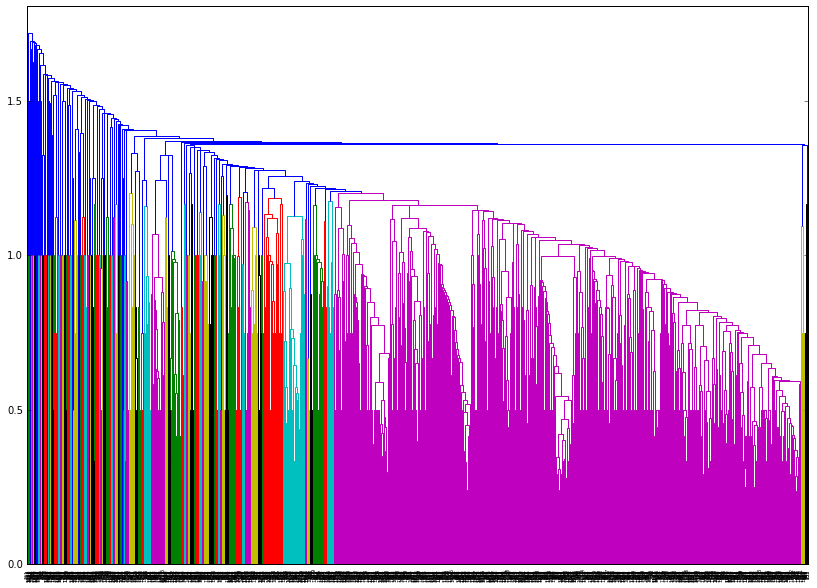

In [19]:
#Visualize Cluster as dendogram
t=hicl.dendrogram(clust_link)


Let's look at clustering level when the number of clusters is 50. We could see one large cluster with 1000+ nodes and many small clusters. 

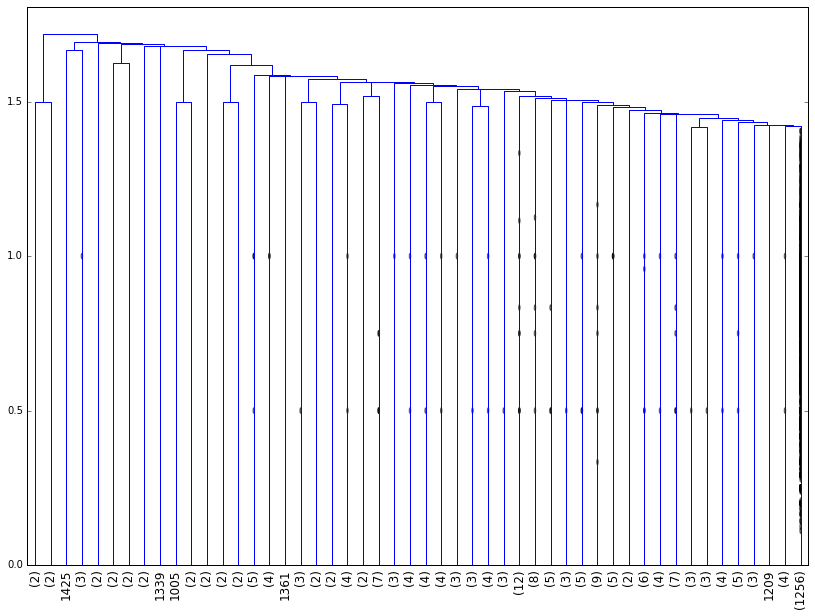

In [20]:
t=hicl.dendrogram(
    clust_link,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=50,  # show top p hierarchy
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)

Let's group reviewers into 100 clusters and extract cluster information.

In [21]:
clusters = hicl.fcluster(clust_link,100, criterion='maxclust')

Let's take a look at one of the clusters.

In [22]:
reviewer_clust={id:clust for id,clust in zip(reviewers_id,clusters)}
print "Reviewers in Cluster 49"
clust49=[k for k in reviewer_clust.keys() if reviewer_clust[k] == 49]
for k in clust49:
    print review_graph.node[k]['name']

Reviewers in Cluster 49
Ralph Martin Smith "Marty"
Michaela
Uriah Rose II "In the house of the hanged, no...
G. Vazquez
Mark
Victoria
B. Benamati


In order to visualize a cluste of reviewers and the products they shared let's extract the nodes and edge list for the cluster we are interested in. 

In [23]:
el=nx.edges(review_graph,clust49)
clust49

['A136M3QYHUVN9A',
 'A28FADP9FITQVK',
 'A7KIY7RDFHRN9',
 'A223S6N0DBQBHP',
 'A2SFO875EQ66AB',
 'A13NZBZQ7ZZG5O',
 'A3C9F3SZWLWDZF']

In [24]:
#Get edge list of the reviewers and get all the nodes related to reviewers in the cluster
n1=[a for a,b in el] #
n1.extend([b for a,b in el])
n1=list(set(n1))

#Products that's shared by the reviewers in the cluster
p1=[n for n in n1 if (n not in clust49)]

In [25]:
pos=pos=nx.spring_layout(review_graph)


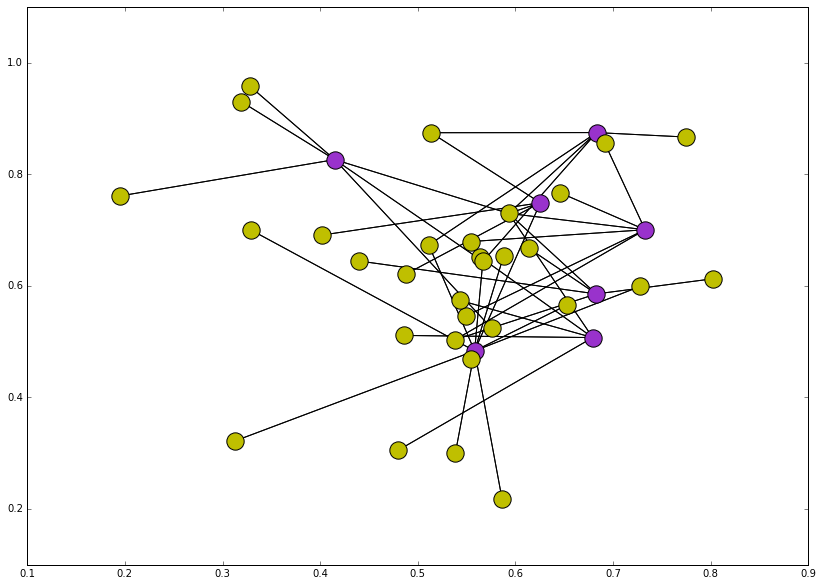

In [26]:
nx.draw_networkx(review_graph,with_labels=False,pos=pos,font_size=12,nodelist=clust49,edgelist=el,
                 node_color='darkorchid')
nx.draw_networkx(review_graph,with_labels=False,pos=pos,font_size=12,nodelist=p1,
                 edgelist=el,node_color='y')

By converting the review data into a two node network and making use of Bipartite network projection we could obtain links between reviewers. Using a weighted projection we could come up with the distance between two reviewers based on the number shared reviews and then use this information to cluster reviewers. 

### Product Network
Similar to reviewer anlysis did above we could used biparitite project on products to come up with links between products and cluster products. 

In [27]:
product_network=bi.weighted_projected_graph(review_graph,products)
degrees = nx.degree(product_network)
max_degree=max(degrees,key=degrees.get)
print "Max number of degree(Shared reviews): ",degrees[max_degree]
print "Product with max degree: ", product_network.node[max_degree]["name"]
min_degree=min(degrees,key=degrees.get)
print "Min degree  of reveiewer ",degrees[min_degree]
print "Product with min degree ",product_network.node[min_degree]["name"]

Max number of degree(Shared reviews):  564
Product with max degree:  706
Min degree  of reveiewer  18
Product with min degree  780


In [28]:
distance_dictp=nx.all_pairs_dijkstra_path_length(product_network,weight="distance")

In [29]:
dist_dfp=pd.DataFrame.from_dict(distance_dictp)
product_id=list(dist_dfp.columns.values)
dist_matp=dist_dfp.as_matrix()
dist_matp.shape

(900, 900)

In [30]:
condensed_distp=ssd.squareform(X=dist_matp,force='tovector',checks=False)
clust_linkp=hicl.linkage(condensed_distp,method='average')

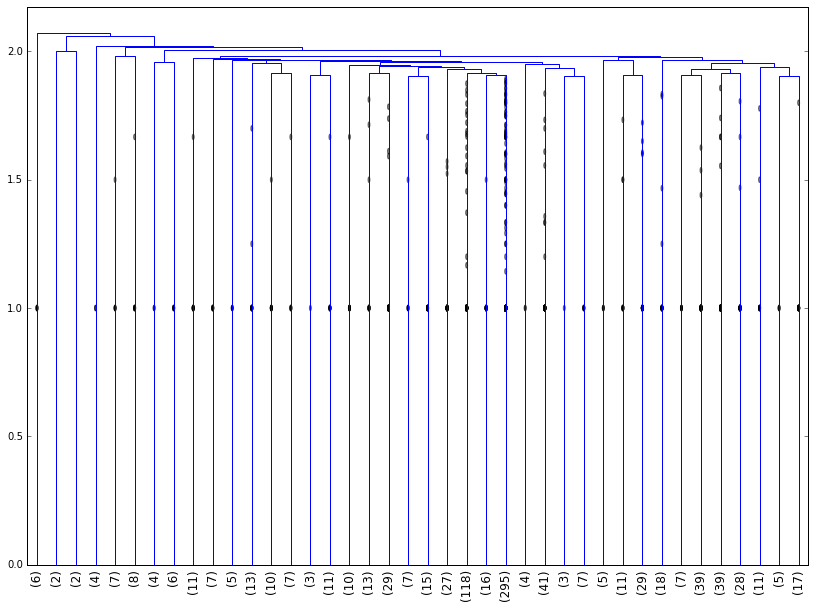

In [31]:
t=hicl.dendrogram(
    clust_linkp,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=40,  # show top p hierarchy
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)

In [32]:
clustersp = hicl.fcluster(clust_linkp,100, criterion='maxclust')

product_clust={id:clust for id,clust in zip(product_id,clustersp)}
clust49p=[k for k in product_clust.keys() if product_clust[k] == 49]
print "Products in Cluster 49\n",clust49p

Products in Cluster 49
['B000EEHMXA', 'B0002E2TTO', 'B0002GZBNS', 'B0002GXZK4', 'B001PGXJGU', 'B000P5OUCE', 'B007IHYBV2', 'B0002H04NE', 'B007TGWQZ0', 'B0002Y6BJI', 'B0002GZBLU', 'B000RW0GT6', 'B0009H00WW', 'B0002E2VXS', 'B005A09I7Q', 'B0002E37G8', 'B000ARH3M6', 'B0002H0KG0']


#### Visualize Product Cluster

In [33]:
elp=nx.edges(review_graph,clust49p)
n1=[a for a,b in elp] #
n1.extend([b for a,b in elp])
n1=list(set(n1))
pr1=[n for n in n1 if (n not in clust49p)]


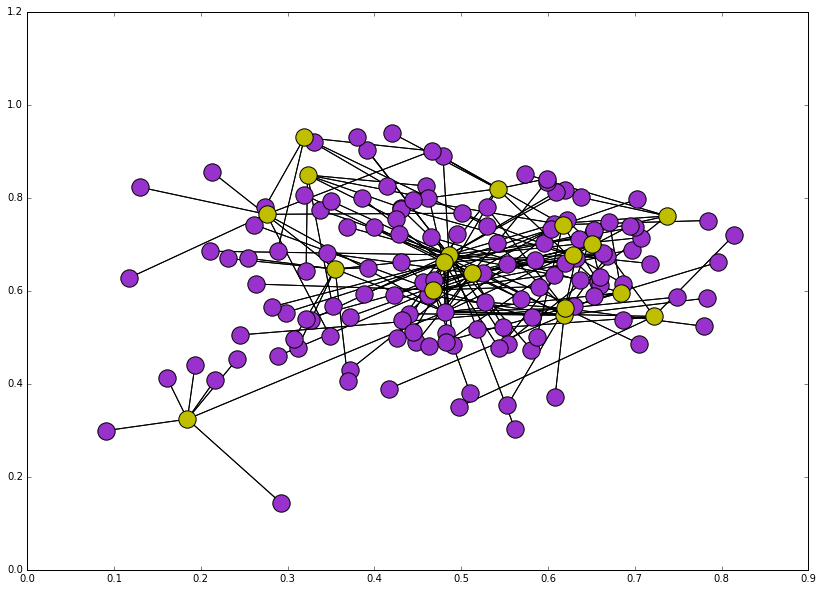

In [34]:
nx.draw_networkx(review_graph,with_labels=False,pos=pos,font_size=12,nodelist=pr1,edgelist=elp,
                 node_color='darkorchid')
nx.draw_networkx(review_graph,with_labels=False,pos=pos,font_size=12,nodelist=clust49p,
                 edgelist=elp,node_color='y')

Let's check the products in a cluster

In [35]:
#Products in the cluster
clust49p

['B000EEHMXA',
 'B0002E2TTO',
 'B0002GZBNS',
 'B0002GXZK4',
 'B001PGXJGU',
 'B000P5OUCE',
 'B007IHYBV2',
 'B0002H04NE',
 'B007TGWQZ0',
 'B0002Y6BJI',
 'B0002GZBLU',
 'B000RW0GT6',
 'B0009H00WW',
 'B0002E2VXS',
 'B005A09I7Q',
 'B0002E37G8',
 'B000ARH3M6',
 'B0002H0KG0']

Checking the amazon website with amazon product ids revealed that many of the above products are related to mandolin (a string musical instrument) and guitar. This indicates that guitar products could potentially be cross selled to mandolin buyers and vice versa.

### Text Analysis to predict rating

In [36]:
review_text = reviews_df["reviewText"]

### Text normalization

In order to extract features to be used for prediction we need to normalize text.

Following normalization techniques are used to normalize the text
- Convert text to lower case
- Replace special characters with space
- Remove stop words
- Stem the words
- Remove words that are less than two characters



In [37]:
#Function to normalize text
def norm_text(text):
    #To lowercase
    text=text.lower()
    #Remove special characters
    text=re.sub("[^a-zA-Z]", " ",text)
    #Split to words
    words = nltk.word_tokenize(text)
    #Stem words
    porter = nltk.PorterStemmer()
    words=[porter.stem(w) for w in words]
    #Keep only words that are 3 or more character long
    words=[w for w in words if len(w) > 2]
    #Remove stop words
    words=[w for w in words if w not in nltk.corpus.stopwords.words('english')]
    return(" ".join(words))

norm_text("Testing Function normalize to see if it works fine")

u'test function normal see work fine'

In [38]:
processed_text =[norm_text(t) for t in review_text]
processed_text[0:3]

[u'much write doe exactli suppos filter pop sound record much crisp one lowest price pop filter amazon might well buy honestli work despit price',
 u'product doe exactli quit afford realiz doubl screen arriv even better expect bonu one screen carri small hint smell old grape candi use buy reminisc sake stop put pop filter next nose smell record dif need pop filter thi work well expens one may even come pleas aroma like mine buy thi product',
 u'primari job thi devic block breath would otherwis produc pop sound allow voic pass notic reduct volum high frequenc doubl cloth filter block pop let voic color metal clamp mount attach mike stand secur enough keep attach goos neck need littl coax stay put']

### Feature Extraction - Bag of words Technique

Many of the statistical learning algorithms works only with numeric data. The bag-of-words is a technique used in natural language processing in which a text is represented as the set of its words, disregarding grammar and  word order. Each word is considered as a feature and the count of the word in that text considered as the value for the feature. 

In [39]:
#Create bag of words
vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 500) #Use 500 most frequent words
bag_of_words = vectorizer.fit_transform(processed_text).toarray()
print "Bag of words array:",bag_of_words.shape
#Get word feature
feat_names=vectorizer.get_feature_names()

Bag of words array: (10261, 500)


In [40]:
review_label=reviews_df["overall"].tolist()

### NLTK Naive Bayes
Let's try NLTK Navie Bayes to classify reviews. NLTK uses Bayes rule to express express P(label|features) in terms of P(label) and P(features|label). The algorithms assumes that all features are independent of each other and hence called Naive Bayes. As NLTK Navie Bayes expects nominal values in a list of dictionary we shall convert the word frequency to word presence (i.e. logical indicating if the word is present in the review or not) and create list of dictionary. 

In [41]:
train_label=review_label[0:8000]
test_label=review_label[8000:]
train=bag_of_words[0:8000,]
test=bag_of_words[8000:,]
#Covert to word presence dictionary
train_dict=[(dict(zip(feat_names,row)),train_label[index]) 
                   for index,row in enumerate(train.astype(bool))]
classifier = nltk.NaiveBayesClassifier.train(train_dict)



In [42]:
test_dict=[(dict(zip(feat_names,row)),test_label[index]) 
           for index,row in enumerate(test.astype(bool))]
print "Training Accuracy:",nltk.classify.accuracy(classifier,train_dict)
print "Test Accuracy:",nltk.classify.accuracy(classifier,test_dict)

Training Accuracy: 0.64875
Test Accuracy: 0.579831932773


In [43]:
t=classifier.classify_many([dict(zip(feat_names,row)) for row in test.astype(bool)])

In [44]:
import sklearn.metrics as met
print "Confusion Matrix"
met.confusion_matrix(test_label,t)

Confusion Matrix


array([[   6,   11,    6,    5,   30],
       [   5,   11,   10,    7,   31],
       [   6,   20,   19,   45,   93],
       [   2,   19,   42,  137,  258],
       [   3,   57,   71,  229, 1138]])

#### Analysis of review text
The model provides an accuracy of 57% which is respectable given the multi-class classification, real world data and the relatively small number of observations. By looking at the word importance we could get some area of improvement. For example the word software seems to indicate a poor rating (rating of 2.0) which probably indicates the software accompanying product need improvement. 

In [45]:
classifier.show_most_informative_features(10)

Most Informative Features
                  return = True              1.0 : 5.0    =     13.1 : 1.0
                  expect = True              2.0 : 1.0    =     10.0 : 1.0
                    hope = True              2.0 : 5.0    =      8.4 : 1.0
                 softwar = True              2.0 : 5.0    =      8.0 : 1.0
              disappoint = True              1.0 : 4.0    =      7.4 : 1.0
                  awesom = True              5.0 : 3.0    =      7.3 : 1.0
                  packag = True              1.0 : 2.0    =      5.8 : 1.0
                   snark = True              2.0 : 5.0    =      5.8 : 1.0
                 probabl = True              2.0 : 1.0    =      5.6 : 1.0
                  receiv = True              1.0 : 5.0    =      5.6 : 1.0


#### SVM Clustering

Support Vector Machines is another popular algorithm used for text classification. SVM model is a representation of data as points in space, mapped so that the points of separate categories are divided by a clear gap that is as wide as possible. For prediction the given points are mapped into that same space and predicted to belong to a category based on which side of the gap they fall.


In [46]:
svm_classifer=svm.SVC().fit(train,train_label)    
print "Training Accuracy:",svm_classifer.score(train,train_label)
print "Testing Accuracy:",svm_classifer.score(test,test_label)

Training Accuracy: 0.681625
Testing Accuracy: 0.66253869969


### Conclusion

This project demonstrated how a network could be constructed from the product review data and network analysis technique could be used to infer useful information. A bipartite network of reviewers and products is constructed from the review data. Using unsupervised hierarchal clustering alogrithm the reviewers and products are grouped into clusters based on the shared reviews. The analysis of clustering revealed that related products are grouped together and thus represented opportunity for cross selling. By processing review and using supervised learning algorithms such as Naive Bayes and Support Vector Machines we were able to come up with prediction model for rating. By analyzing the word importance in the model we could get some idea about the factors that affect rating. 